In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    
    library(gtools, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    library(data.table, quietly = T) 
    library(aricode, quietly = T)
    
    library(ggplot2, quietly = T)
    library(ggpubr, quietly = T)
    library(RColorBrewer, quietly = T)

})

sctype_path = '/data2/hratch/Software/'
data_path = '/data3/hratch/norcross_abc/'

In [2]:
abc.integrated<-readRDS(paste0(data_path, 'interim/abc_sctype_annotated.RDS'))

# Re-annotation

Based on Wilcoxon marker/scType annotations results from script 01Bi, we rename: myeloid DC clusters and cluster 5 basophils as cDC,  Cluster 13 & 16 progenitor cells as Xcr1+ DC, Cluster 12 as unknown

In [3]:
clusters<-as.character(abc.integrated$seurat_clusters)
cell.types<-as.character(abc.integrated$Cell.Type.ScType)

cell.mapper = list('5'= 'Conventional Dendritic cells - Group 2', '12' = 'Unknown', 
                   '13' = 'Xcr1+ Dendritic cells - Group 2', '16' = 'Xcr1+ Dendritic cells - Group 1')

for (cl in names(cell.mapper)){
    if (length(unique(cell.types[(clusters == cl)])) != 1){stop('More than 1 cell type')}
    cell.types[(clusters == cl)] = cell.mapper[[cl]]  
}
cell.types[cell.types == 'Myeloid Dendritic cells'] = 'Conventional Dendritic cells - Group 1'


## Subclustering

We will subcluster some clusters due to uncertainties from the Wilcoxon marker results

In [4]:
pca.var<-function(so, n_pcs_test = 100, pc.thresh = 0.15){
    total_variance <- sum(matrixStats::rowVars(so@assays$integrated@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point()
    if (n_pcs <= n_pcs_test){g<-g+geom_vline(xintercept = n_pcs, color = 'blue')}
    
    return(list(n.pcs = min(30, n_pcs), pc.var.graph = g))
}

subcluster<-function(so, cluster_label, resolution = 0.5, n_pcs_test = 100, cluster.title = NULL){
    suppressWarnings({
        suppressMessages({
            if (is.list(cluster_label)){
                so.subset<-subset(so, seurat_clusters %in% cluster_label)
            }else{
                so.subset<-subset(so, seurat_clusters == cluster_label)
            }
            
            so.subset<-RunPCA(so.subset, npcs = n_pcs_test, verbose=F)
            # npcs is min(PC where more than 0.1% of var is no longer explained or 30)
            pca.res<-pca.var(so.subset, n_pcs_test = n_pcs_test) 
            so.subset <- FindNeighbors(so.subset, reduction = "pca", dims = 1:pca.res$n.pcs, 
                                      verbose = F)
            so.subset <- FindClusters(so.subset, resolution = resolution, verbose = F)
            so.subset <- RunUMAP(so.subset, reduction = "pca", dims = 1:pca.res$n.pcs, verbose = F)
        })
    })
    
    if (is.null(cluster.title)){cluster.title<-paste0('Cluster : ', cluster_label)}
    g<-DimPlot(so.subset) + ggtitle(cluster.title)
    
    print(paste0('The number of cells is: ', dim(so.subset)[[2]]))
    print(paste0('The number of PCs is: ', pca.res$n.pcs))
    print(paste0('The number of sub-clusters is: ', length(unique(so.subset$seurat_clusters))))
    
    res<-list(so.subset = so.subset, 
              n.pcs = pca.res$n.pcs, pc.var.graph = pca.res$pc.var.graph, 
             umap.graph = g)
    

    return(res)
    
}

In [8]:
md<-abc.integrated@meta.data

Cluster 22:

In [5]:
res.c22<-subcluster(so = abc.integrated, cluster_label = '22', resolution = 0.5)

[1] "Additional variance explained is <0.15% at Inf pcs"
[1] "The number of cells is: 310"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 3"


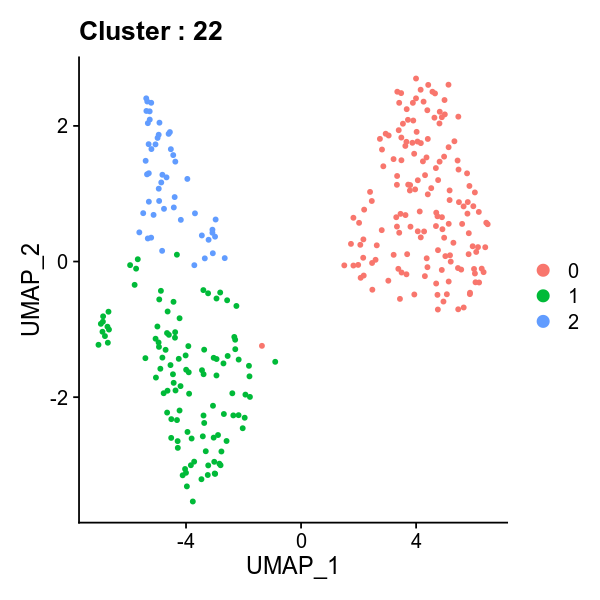

In [6]:
h_ = 5
w_ = 5
options(repr.plot.height=h_, repr.plot.width=w_)

res.c22$umap.graph

In [10]:
unique(as.character(md[md$seurat_clusters == '22', 'Cell.Type.ScType']))

[1] "Plasmacytoid Dendritic cells"

T-cells

In [11]:
cd8s<-c('0', '3', '6', '10')
cd4s<-c('2', '15', '21')
t.cells<-as.list(c(cd8s, cd4s, '24'))

res.tcells<-subcluster(so = abc.integrated, cluster_label = t.cells, resolution = 0.5, cluster.title = 'T cells')
# saveRDS(res.tcells, paste0(data_path, 'interim/subcluster_markers.RDS'))

[1] "Additional variance explained is <0.15% at 34 pcs"
[1] "The number of cells is: 14214"
[1] "The number of PCs is: 30"
[1] "The number of sub-clusters is: 16"


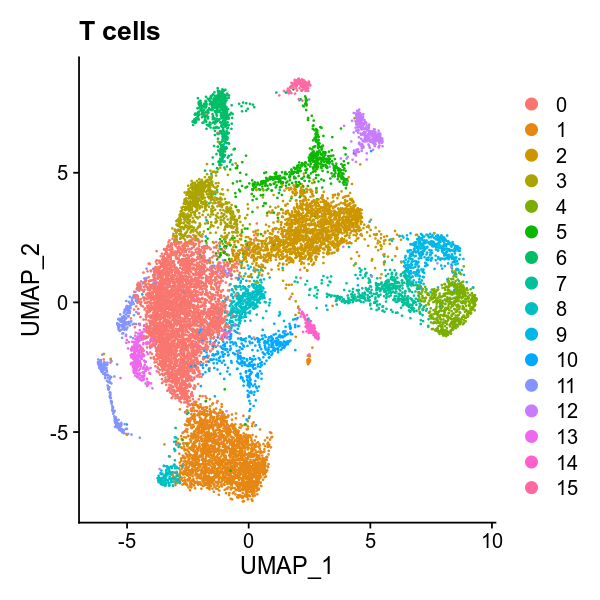

In [12]:
h_ = 5
w_ = 5
options(repr.plot.height=h_, repr.plot.width=w_)

res.tcells$umap.graph

In [13]:
cluster.nmi<-aricode::NMI(res.tcells$so.subset$seurat_clusters, abc.integrated[, colnames(res.tcells$so.subset)]$seurat_clusters)
print(paste0('The NMI between the original T cell cluster labels and the subcluster labels is ', cluster.nmi))

[1] "The NMI between the original T cell cluster labels and the subcluster labels is 0.643718443323598"


## Markers

We repeat the marker wilcoxon method from before (02Ci), but this time, comparing each sub-cluster to all other cells in the dataset.

### Mapping

First, must map cluster labels of subsets. The largest cluster label currently is cluster 26. So for each subclusters, we will re-label them starting from cluster 27. 

In [14]:
relabel.clusters<-function(so.subset, n.clusters.tot){

    md<-so.subset@meta.data['seurat_clusters']
    n.clusters<-length(unique(md$seurat_clusters))
    
    n.clusters.start<-n.clusters.tot + 1
    
    cluster.labels<-as.character(sort(unique(as.numeric(md$seurat_clusters))))
    cluster.labels.no<-as.character(n.clusters.start:(n.clusters.start + n.clusters-1))
    names(cluster.labels.no)<-as.character(sort(unique(as.numeric(md$seurat_clusters))) - 1)

    md[['cluster.labels.no']]<-cluster.labels.no[md$seurat_clusters]
    so.subset@meta.data<-md
    
    return(list(so.subset = so.subset, max.cluster = as.numeric(max(cluster.labels.no))))
}

In [15]:
mapper.no<-c()
n.clusters.tot<-max(as.numeric(abc.integrated$seurat_clusters))-1

subclusters<-list(res.c22, res.tcells)
for (i in seq_along(subclusters)){
    res<-subclusters[[i]]
    cluster.relabel<-relabel.clusters(so.subset = res$so.subset, n.clusters.tot = n.clusters.tot)
    
    n.clusters.tot<-cluster.relabel$max.cluster
    res[['so.subset']]<-cluster.relabel$so.subset
    subclusters[[i]]<-res
    
    mapper.no<-c(mapper.no, setNames(res$so.subset@meta.data$cluster.labels.no, rownames(res$so.subset@meta.data)))

}

In [16]:
md<-abc.integrated@meta.data

md[['seurat_subcluster_no']]<-as.character(md$seurat_clusters)
md[names(mapper.no), 'seurat_subcluster_no']<-unname(unlist(mapper.no))
md[['seurat_subcluster_no']]<-factor(x = md$seurat_subcluster_no,
                                     levels = mixedsort(unique(as.character(md$seurat_subcluster_no))))
abc.integrated@meta.data<-md

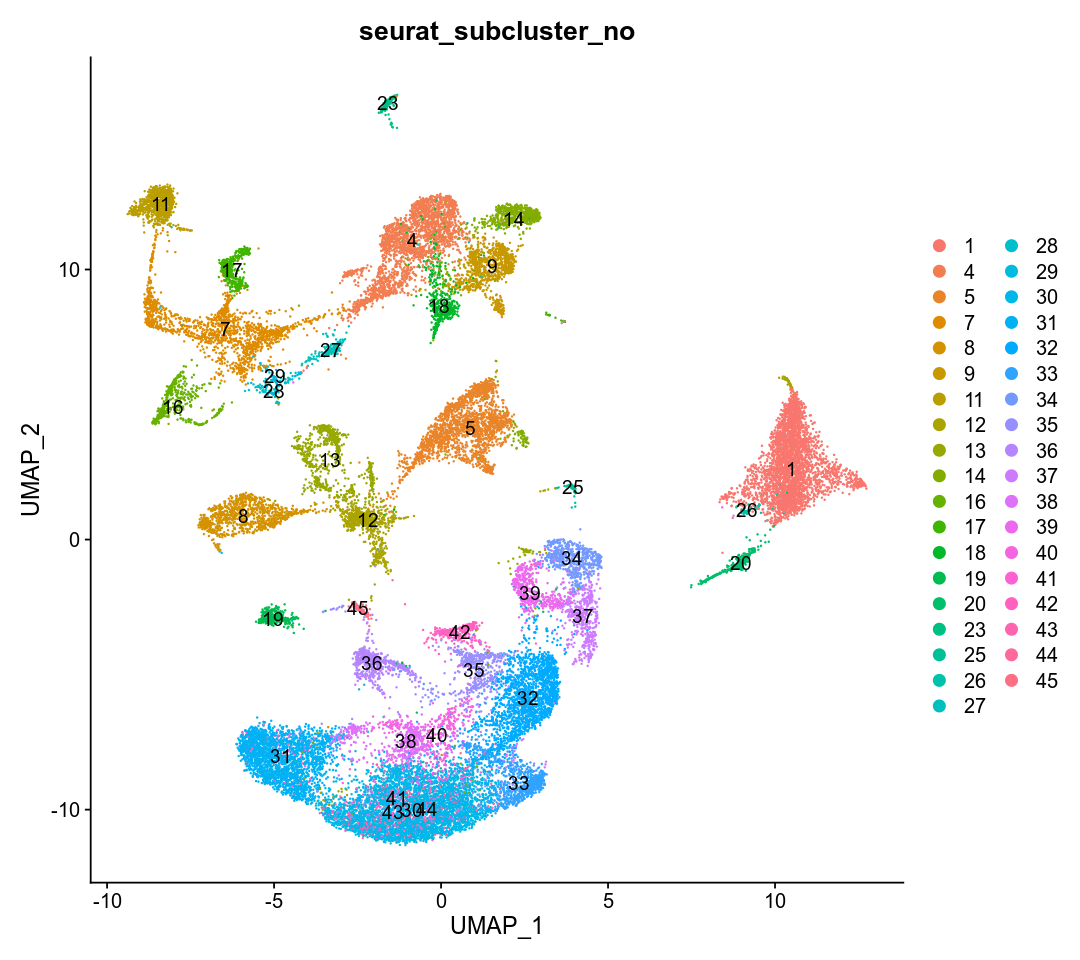

In [17]:
h_ = 8
w_ = 9
options(repr.plot.height=h_, repr.plot.width=w_)

DimPlot(abc.integrated, 
       group.by = 'seurat_subcluster_no', label = T)

### DE markers

In [18]:
Idents(abc.integrated)<-'seurat_subcluster_no'
subclusters<-as.character(mixedsort(unique(md[md$seurat_clusters %in% c(unlist(t.cells), '22'), 'seurat_subcluster_no'])))
subclusters

[1] "27" "28" "29" "30" "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41"
[16] "42" "43" "44" "45"

Here are all the unique mappings from the original cluster label to the sub-cluster label (note, there is overlap, e.g. both cluster 0 and cluster 2 map to subcluster 30, since we  grouped T cells together prior to subclustering). Original clusters are the rows, subclusters are the columns:

In [19]:
cn<-c('seurat_clusters', 'seurat_subcluster_no')
cluster.map<-md[md$seurat_clusters %in% c(unlist(t.cells), '22'), cn]
cell.counts<-dplyr::count(cluster.map, seurat_clusters, seurat_subcluster_no)
cell.counts<-dcast(cell.counts, seurat_clusters ~ seurat_subcluster_no, value.var="n")
rownames(cell.counts)<-cell.counts$seurat_clusters
cell.counts<-cell.counts[, colnames(cell.counts) != 'seurat_clusters']
cell.counts[is.na(cell.counts)]<-0
# write.csv(cell.counts, paste0(data_path, 'interim/subcluster_mapper.csv'))

# cluster.map<-md[md$seurat_clusters %in% c(unlist(t.cells), '22'), cn]
# cluster.map<-cluster.map %>% group_by(Cell.Type.ScType, seurat_clusters, seurat_subcluster_no) %>% summarize(count=n())
# cluster.map<-cluster.map[with(cluster.map, order(seurat_clusters, seurat_subcluster_no)), ] 

cell.counts

Warning message in dcast(cell.counts, seurat_clusters ~ seurat_subcluster_no, value.var = "n"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(cell.counts). In the next version, this warning will become an error.”


,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,4020,14,29,7,0,11,1,0,366,0,421,256,3,304,124,0
2,0,0,0,13,2336,0,0,0,9,0,0,132,0,4,80,2,1,2,0
3,0,0,0,17,3,1879,8,0,540,1,1,3,2,8,3,7,0,2,2
6,0,0,0,3,1,54,0,606,0,0,510,0,461,9,0,1,0,0,0
10,0,0,0,122,0,9,770,0,29,2,3,5,0,4,9,0,0,8,0
15,0,0,0,4,0,0,3,0,2,535,0,1,0,4,0,0,0,0,0
21,0,0,0,0,0,0,0,0,5,0,0,1,0,0,0,308,0,0,0
22,153,108,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,0,0,0,126


In [20]:
# markers.wilcoxon<-list()
# for (subcluster in subclusters){
#     print(subcluster)
#     de.res<-FindMarkers(object = abc.integrated, 
#                                     ident.1 = subcluster,
#                                     assay = 'RNA', only.pos = T, 
#                                        slot = 'data', test.use = 'wilcox', 
#                                        min.pct = 0.25, # stringent since markers
#                                         logfc.threshold = 0.5, 
#                                       )
#     de.res[['gene']]<-rownames(de.res)
#     de.res[['seurat_cluster_no']]<-subcluster
    
#     markers.wilcoxon[[subcluster]]<-de.res
# }
# saveRDS(markers.wilcoxon, paste0(data_path, 'interim/subcluster_markers.RDS'))
markers.wilcoxon<-readRDS(paste0(data_path, 'interim/subcluster_markers.RDS'))

In [22]:
# format markers
marker.excel<-function(marker, de.type = 'wilcoxon'){
    markers_workbook<-createWorkbook()
    for (cluster in mixedsort(unique(marker$seurat_cluster_no))){
        de.res.cl<-as.data.frame(marker[marker$seurat_cluster_no == cluster, ])
        rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]

        addWorksheet(markers_workbook, cluster)
        writeData(markers_workbook, sheet = cluster, x = de.res.cl)
    }
    saveWorkbook(markers_workbook, overwrite = T, 
                 paste0(data_path, 'interim/', de.type, '_subcluster_markers.xlsx'))
}

padj.thresh<-0.1
lfc.thresh<-0.5
# additional formatting and filtering
marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= padj.thresh,] # threshold on p_adj
marker<-marker[marker$avg_log2FC > lfc.thresh,] # further threshold on LFC
de.counts<-table(marker$seurat_cluster_no)
marker<-marker[with(marker, order(seurat_cluster_no, -avg_log2FC)), ] # sort by effect size
# md.subs<-md[md$seurat_subcluster_no %in% subclusters ,]
# mapper<-setNames(md.subs$seurat_subcluster_no, md.subs$seurat_subcluster_no)
# marker[['seurat_subcluster_no']]<-unlist(unname(mapper[marker$seurat_cluster_no]))
marker.excel(marker) # save to excel file

The number of DE genes per subcluster:

In [23]:
de.counts


  27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42 
1711 4588 1795  129   90  798  286 3514  121   93 2752  160 2976  334  103  190 
  43   44   45 
  77  140  355 

#### Compare with original markers from previous annotation

In [24]:
og.markers<-openxlsx::read.xlsx(paste0(data_path, 'interim/Marco-Hratch_cluster-associated_genes_12-9-22.xlsx'))
og.intersections <- data.frame(matrix(ncol = dim(og.markers)[[2]], nrow = length(subclusters)))
colnames(og.intersections) <- colnames(og.markers)
rownames(og.intersections)<-subclusters
for (cl in subclusters){
    cl.markers<-marker[marker$seurat_cluster_no == cl, 'gene']
    og.intersections[cl, ]<-sapply(og.markers, function(x) length(intersect(x, cl.markers)))                         
}
write.csv(og.intersections, paste0(data_path, 'interim/subcluster_intersection_Marcogenes.csv'))
og.intersections

,Tfh,Th1,Treg,CD4.naivelike,CD8.naivelike,CD8.early.activ,CD8.EffMem,CD8.ExPrec,CD8Ex,NK,Bcells,cDC,XCR1+DC,pDC,Mf,monocytes,Mono-Mf,Granuloc,Basophils
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
27,70,19,23,15,7,11,24,46,62,81,65,404,222,237,2,266,122,158,44
28,184,24,60,35,16,30,83,67,150,184,159,456,555,456,6,549,280,398,151
29,51,14,25,12,11,29,55,35,47,106,98,299,374,278,4,484,185,293,93
30,56,77,59,120,121,104,77,69,29,36,8,0,2,11,0,0,1,6,2
31,37,56,58,86,64,59,39,45,20,20,7,0,0,4,0,4,1,8,0
32,107,278,233,211,212,209,273,345,79,176,67,23,32,78,1,17,34,92,27
33,73,120,103,157,193,153,153,113,48,110,21,2,10,24,0,13,4,39,6
34,281,247,243,220,198,189,334,304,219,295,165,119,280,210,3,109,164,180,169
35,38,107,92,60,65,69,106,81,29,50,12,3,8,12,0,6,6,19,9


## ScType re-annotation

We also re-annotate the sub-clusters using ScType. While we probably won't use any of these annotations directly, they can perhaps guide the manual identification using the DE Markers.

In [25]:
source(paste0(sctype_path, 'sc-type/', 'R/gene_sets_prepare.R'))
source(paste0(sctype_path, 'sc-type/', 'R/sctype_score_.R'))       
db_<-paste0(sctype_path, 'sc-type/', 'ScTypeDB_full.xlsx')

path_to_db_file = db_
cell_type = "Immune system" 

cell_markers = openxlsx::read.xlsx(path_to_db_file)
cell_markers = cell_markers[cell_markers$tissueType == cell_type,] 
cell_markers$geneSymbolmore1 = gsub(" ","",cell_markers$geneSymbolmore1); cell_markers$geneSymbolmore2 = gsub(" ","",cell_markers$geneSymbolmore2)

tissue = "Immune system" 
# prepare gene sets
suppressWarnings({
    suppressMessages({
        gs_list = gene_sets_prepare(db_, tissue)
    })
})

In [26]:
md<-abc.integrated@meta.data

In [27]:
# get cell-type by cell matrix (scores each cell for each cell type)
es.max = sctype_score(scRNAseqData = abc.integrated@assays$integrated@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# merge by cluster by taking the sum of the scores of each cell type
cL_resutls = do.call("rbind", lapply(unique(md$seurat_subcluster_no), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(md[md$seurat_subcluster_no==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(md$seurat_subcluster_no==cl)), 10)
}))

write.csv(cL_resutls, 
         paste0(data_path, 'interim/celltype_subcluster_scores.csv'))

# take max score of each cluster
sctype_scores = cL_resutls %>% group_by(cluster) %>% dplyr::top_n(n = 1, wt = scores)  
sctype_scores[['freq']]<-100*sctype_scores$ncells/sum(sctype_scores$ncells)

sctype_scores[['Confidence']]<-'good'
sctype_scores$Confidence[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "bad"

sctype_scores<-sctype_scores[with(sctype_scores, order(cluster)), ]


In [28]:
prev.annotated<-sctype_scores[!(sctype_scores$cluster %in% subclusters), ]

og.sctype.annotated<-read.csv(paste0(data_path, 'interim/celltype_cluster_scores.csv'))
og.sctype.annotated<-og.sctype.annotated[(colnames(og.sctype.annotated) != 'X')]
og.sctype.annotated = og.sctype.annotated %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  
og.sctype.annotated[['freq']]<-100*og.sctype.annotated$ncells/sum(og.sctype.annotated$ncells)
og.sctype.annotated[['Confidence']]<-'good'
og.sctype.annotated$Confidence[as.numeric(as.character(og.sctype.annotated$scores)) < og.sctype.annotated$ncells/4] = "bad"
og.sctype.annotated<-og.sctype.annotated[with(og.sctype.annotated, order(cluster)), ]
# og.sctype.annotated<-og.sctype.annotated[!(og.sctype.annotated$cluster %in% subclusters), ]
# og.sctype.annotated<-og.sctype.annotated[!(og.sctype.annotated$cluster %in% clusters.drop), ]
og.sctype.annotated<-og.sctype.annotated[og.sctype.annotated$cluster %in% as.character(prev.annotated$cluster), ]

if (identical(prev.annotated$type, og.sctype.annotated$type)){
    print('The re-run ScType annotations match the original ones for clusters that were not sub-clustered or dropped')
}

[1] "The re-run ScType annotations match the original ones for clusters that were not sub-clustered or dropped"


ScType annotates the sub-clusters as follows:

In [29]:
sctype_scores[(sctype_scores$cluster %in% subclusters),]

cluster,type,scores,ncells,freq,Confidence
<fct>,<chr>,<dbl>,<int>,<dbl>,<chr>
27,Plasmacytoid Dendritic cells,423.3507,153,0.4830308,good
28,Progenitor cells,209.3049,108,0.3409629,good
29,Plasmacytoid Dendritic cells,106.4464,49,0.1546961,good
30,Naive CD8+ T cells,6923.2288,4179,13.1933702,good
31,Naive CD4+ T cells,3738.2038,2354,7.4317285,good
32,Memory CD8+ T cells,5003.8062,1971,6.2225730,good
33,CD8+ NKT-like cells,2157.1538,788,2.4877664,good
34,Effector CD8+ T cells,1500.1473,606,1.9131807,good
35,Effector CD4+ T cells,1305.9038,598,1.8879242,good


In [30]:
write.csv(sctype_scores[(sctype_scores$cluster %in% subclusters),], 
                        paste0(data_path, 'interim/celltype_subclusteronly_scores.csv'))

## Final Assignments of Subclusters

Based on the above analyses, we have final assignments for the subclusters:

In [52]:
md<-abc.integrated@meta.data

In [53]:
subclusters<-as.character(md$seurat_subcluster_no)
cell.mapper = list('27'= 'Conventional Dendritic cells - Group 1', '28' = 'Macrophages', '29' = 'Macrophages', 
                  '30' = 'Naive CD8+ T cells', '31' = 'Naive CD4+ T cells', '32' = 'Exh precursor CD8+ T cells', 
                  '33' = 'Early Activated CD8+ T cells - Group 1', '34' = 'Effector/Exhausted CD8+ T cells', 
                  '35' = 'Effector CD4+ T cells', '36' = 'γδ-T cells', '37' = 'Exhausted CD8+ T cells', 
                  '38' = 'Naive/Early Activted ISG CD8+ T cells', '39' = 'Effector/Exhausted CD8+ T cells', 
                  '40' = 'Early Activated CD8+ T cells - Group 2', '41' = 'Naive CD8+ T cells', 
                  '42' = 'Regulatory CD4+ T cells', '43' = 'Naive CD8+ T cells', '44' = 'Naive CD8+ T cells', 
                  '45' = 'γδ-T cells')

for (cl in names(cell.mapper)){
    cell.types[(subclusters == cl)] = cell.mapper[[cl]]  
}

# formatting
md[['Cell.Type.Level2']]<-cell.types
names(md)[names(md) == 'seurat_clusters'] <- 'Seurat.Clusters.Level1'
names(md)[names(md) == 'seurat_subcluster_no'] <- 'Seurat.Clusters.Level2'

md[['Cell.Type.Level1']]<-cell.types
t.cell.subclusters<-setdiff(names(cell.mapper), c('27', '28', '29'))
md[md$Seurat.Clusters.Level2 %in% t.cell.subclusters, 'Cell.Type.Level1']<-'T cells'

# map to short convention and factor
co.names<-c('Pre-B cells', 'Naive B cells', 'T cells', 'Natural killer  cells',
     'Conventional Dendritic cells - Group 1', 'Conventional Dendritic cells - Group 2', 
      'Xcr1+ Dendritic cells - Group 1', 'Xcr1+ Dendritic cells - Group 2',
      'Plasmacytoid Dendritic cells', 'Non-classical monocytes', 'Macrophages',
      'Neutrophils', 'Unknown')

co<-c('Pre-B cells', 'Naive B-cells', 'T-cells', 'NK  cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2','pDC', 
      'ncMono', 'Mf', 'Neutrophils', 'Unknown')
names(co)<-co.names

md[['Cell.Type.Level1']]<-factor(x = unname(co[md$Cell.Type.Level1]), levels = unname(co))

co.names<-c('Pre-B cells', 'Naive B cells', 
      'Naive CD8+ T cells', 'Naive/Early Activted ISG CD8+ T cells', 
      'Early Activated CD8+ T cells - Group 1', 'Early Activated CD8+ T cells - Group 2',
      'Exh precursor CD8+ T cells', 'Effector/Exhausted CD8+ T cells', 'Exhausted CD8+ T cells', 
      'Naive CD4+ T cells', 'Effector CD4+ T cells', 'Regulatory CD4+ T cells', 
      'γδ-T cells', 
      'Natural killer  cells',
     'Conventional Dendritic cells - Group 1', 'Conventional Dendritic cells - Group 2', 
      'Xcr1+ Dendritic cells - Group 1', 'Xcr1+ Dendritic cells - Group 2',
      'Plasmacytoid Dendritic cells', 'Non-classical monocytes', 'Macrophages',
      'Neutrophils', 'Unknown')

co<-c('Pre-B cells', 'Naive B-cells', 'CD8+ TN', 'CD8+ TN/EA-ISG', 'CD8+ TEA_1', 'CD8+ TEA_2', 'CD8+ TEx prec', 
      'CD8+ TE/Ex', 'CD8+ TEx', 'CD4+TN', 'CD4+ TE', 'CD4+ Treg', 'gd-T', 
      'NK  cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2','pDC',
      'ncMono', 'Mf', 'Neutrophils', 'Unknown')
names(co)<-co.names
md[['Cell.Type.Level2']]<-factor(x = unname(co[md$Cell.Type.Level2]), levels = unname(co))

# reorder columns
col.order<-c('Seurat.Clusters.Level1', 'Cell.Type.Level1', 'Seurat.Clusters.Level2', 
              'Cell.Type.Level2', 'Cell.Type.ScType')
other.cols<-setdiff(names(md), col.order)
new.order<-c(other.cols[1:5], col.order, other.cols[6:length(other.cols)])

md<-md[new.order]
abc.integrated@meta.data<-md

Level 1 clusters are prior to subclustering. Level 1 cell types groups all final T cells subtypes into a general T cell group. Level 2 clusters are after subclustering. Level 2 cell types include T cell subtypes. 

In [55]:
level1.unique<-dplyr::distinct(md[col.order[1:2]])
level1.unique<-level1.unique[with(level1.unique, order(Seurat.Clusters.Level1, Cell.Type.Level1)), ]
rownames(level1.unique)<-1:dim(level1.unique)[[1]]
write.csv(level1.unique, paste0(data_path, 'processed/celltype_annotation_level1.csv'))

level2.unique<-dplyr::distinct(md[col.order[3:4]])
level2.unique<-level2.unique[with(level2.unique, order(Seurat.Clusters.Level2, Cell.Type.Level2)), ]
rownames(level2.unique)<-1:dim(level2.unique)[[1]]
write.csv(level2.unique, paste0(data_path, 'processed/celltype_annotation_level2.csv'))

In [69]:
abc.tcells<-res.tcells$so.subset
md.tcells<-abc.tcells@meta.data
md.tcells<-md.tcells[names(md.tcells)[1:4]]
for (col.name in c('Seurat.Clusters.Level2', 'Cell.Type.Level2')){
    md.tcells[[col.name]]<-droplevels(md[rownames(md.tcells), ][[col.name]])
}
abc.tcells@meta.data<-md.tcells

In [57]:
saveRDS(abc.integrated, paste0(data_path, 'processed/abc_annotated.RDS'))
saveRDS(abc.tcells, paste0(data_path, 'processed/abc_tcells.RDS'))

# Visualize

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



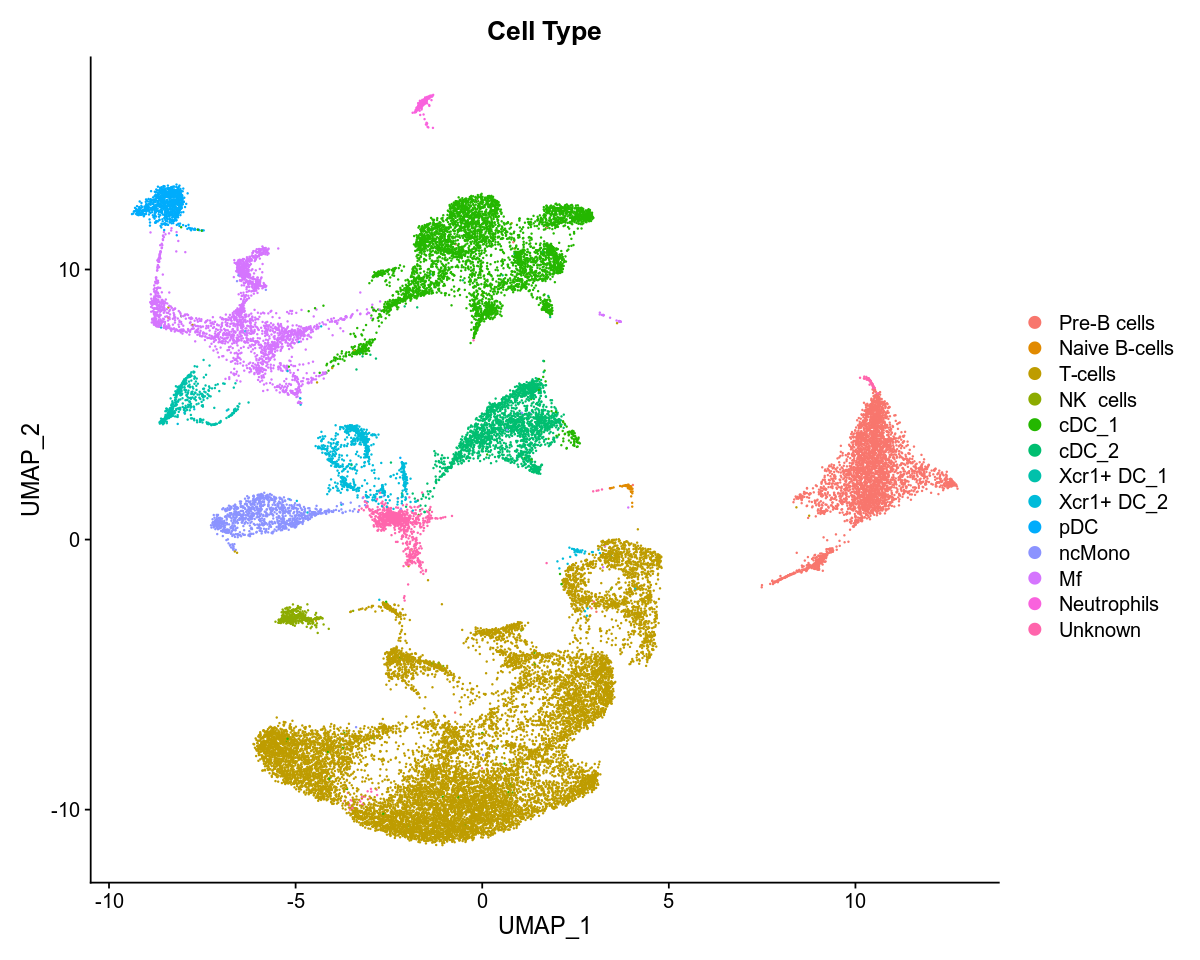

In [58]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

g1 <- DimPlot(abc.integrated, reduction = "umap", group.by = "Cell.Type.Level1", shuffle = T, label = F)+
ggtitle('Cell Type')

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'UMAP_celltype_level1_final', ext), g1)}     
g1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



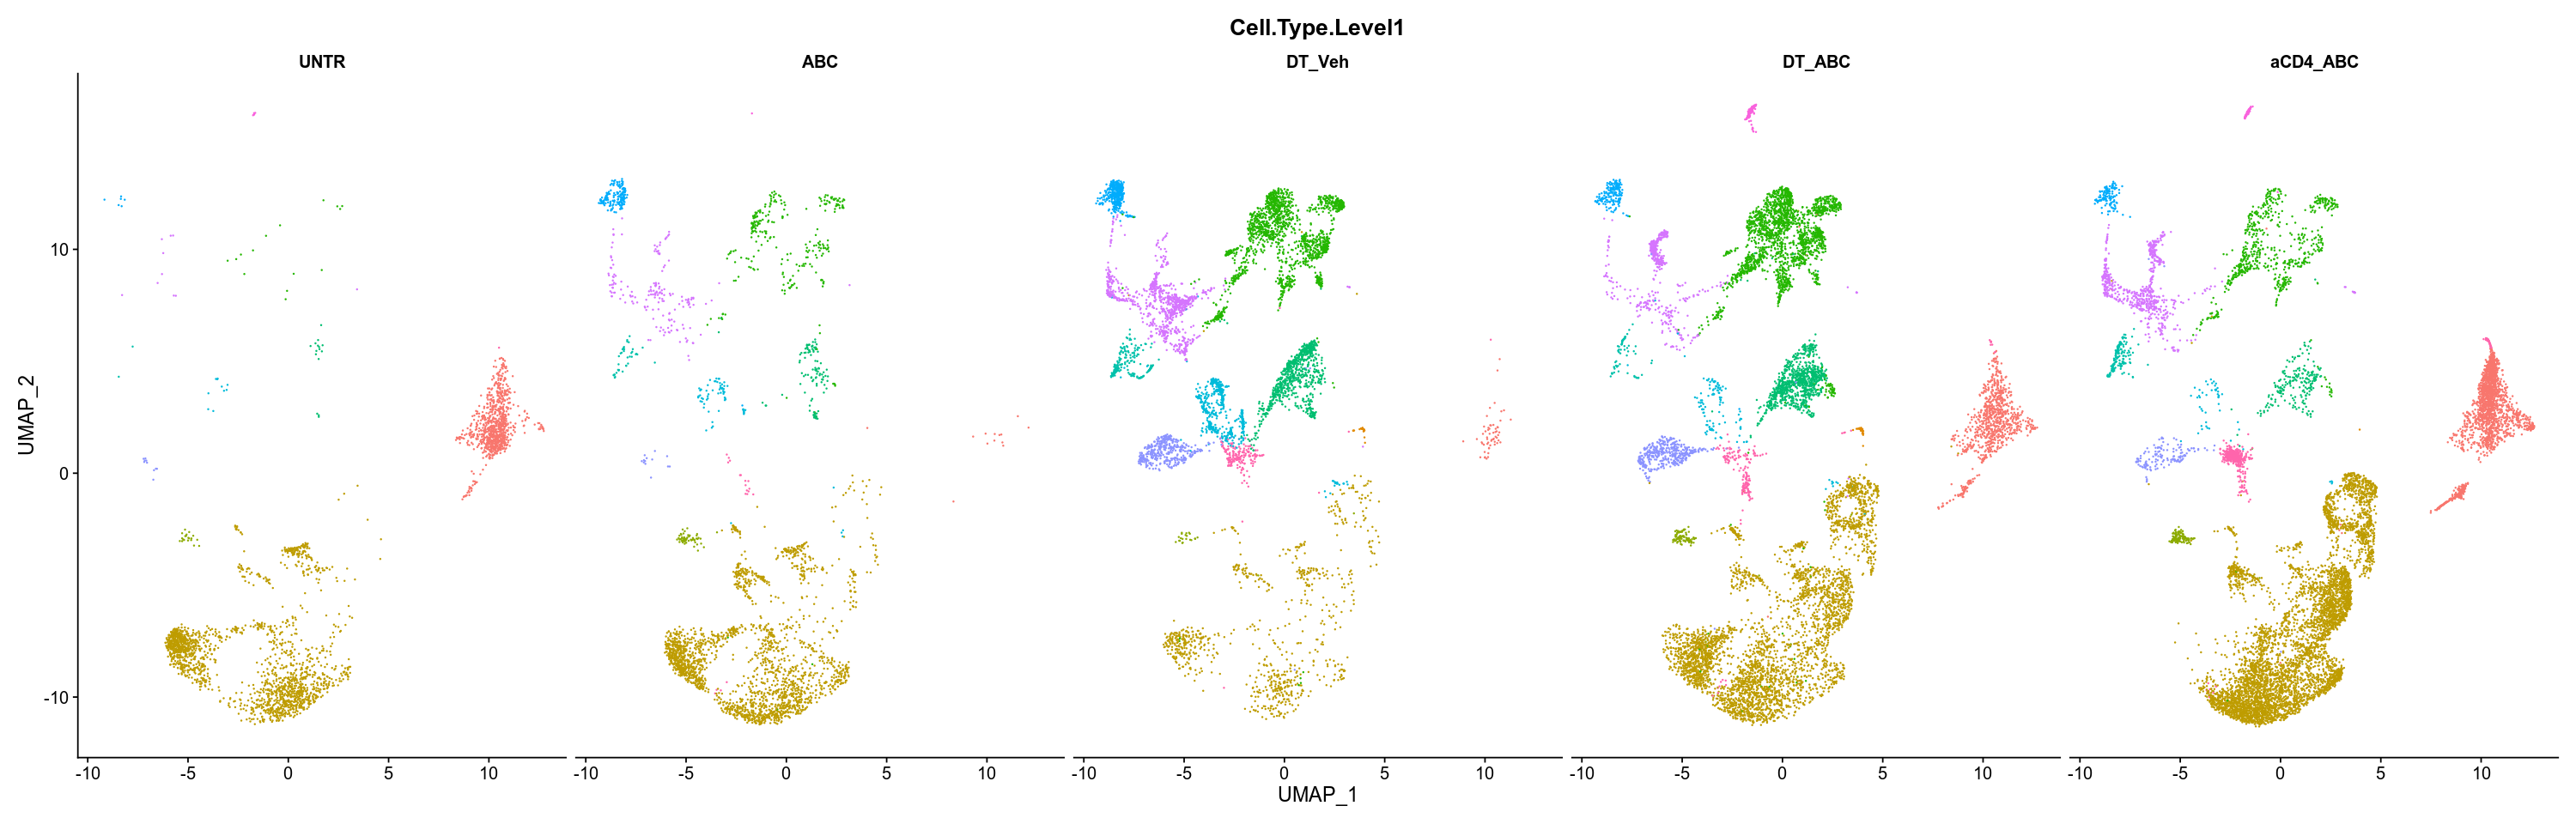

In [59]:
h_ = 8
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

g2 <- DimPlot(abc.integrated, reduction = "umap", group.by = "Cell.Type.Level1", split.by = 'orig.ident', 
              shuffle = T, label = F) + NoLegend()

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'UMAP_celltype_contexts_level1_final', ext), g2)}     
g2

In [60]:
markers<-openxlsx::read.xlsx(paste0(data_path, 'interim/canonical_markers.xlsx'))$gene
markers<-unname(sapply(markers, function(x) paste0(toupper(substr(x, 1, 1)), tolower(substr(x, 2, nchar(x))), sep="")))


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



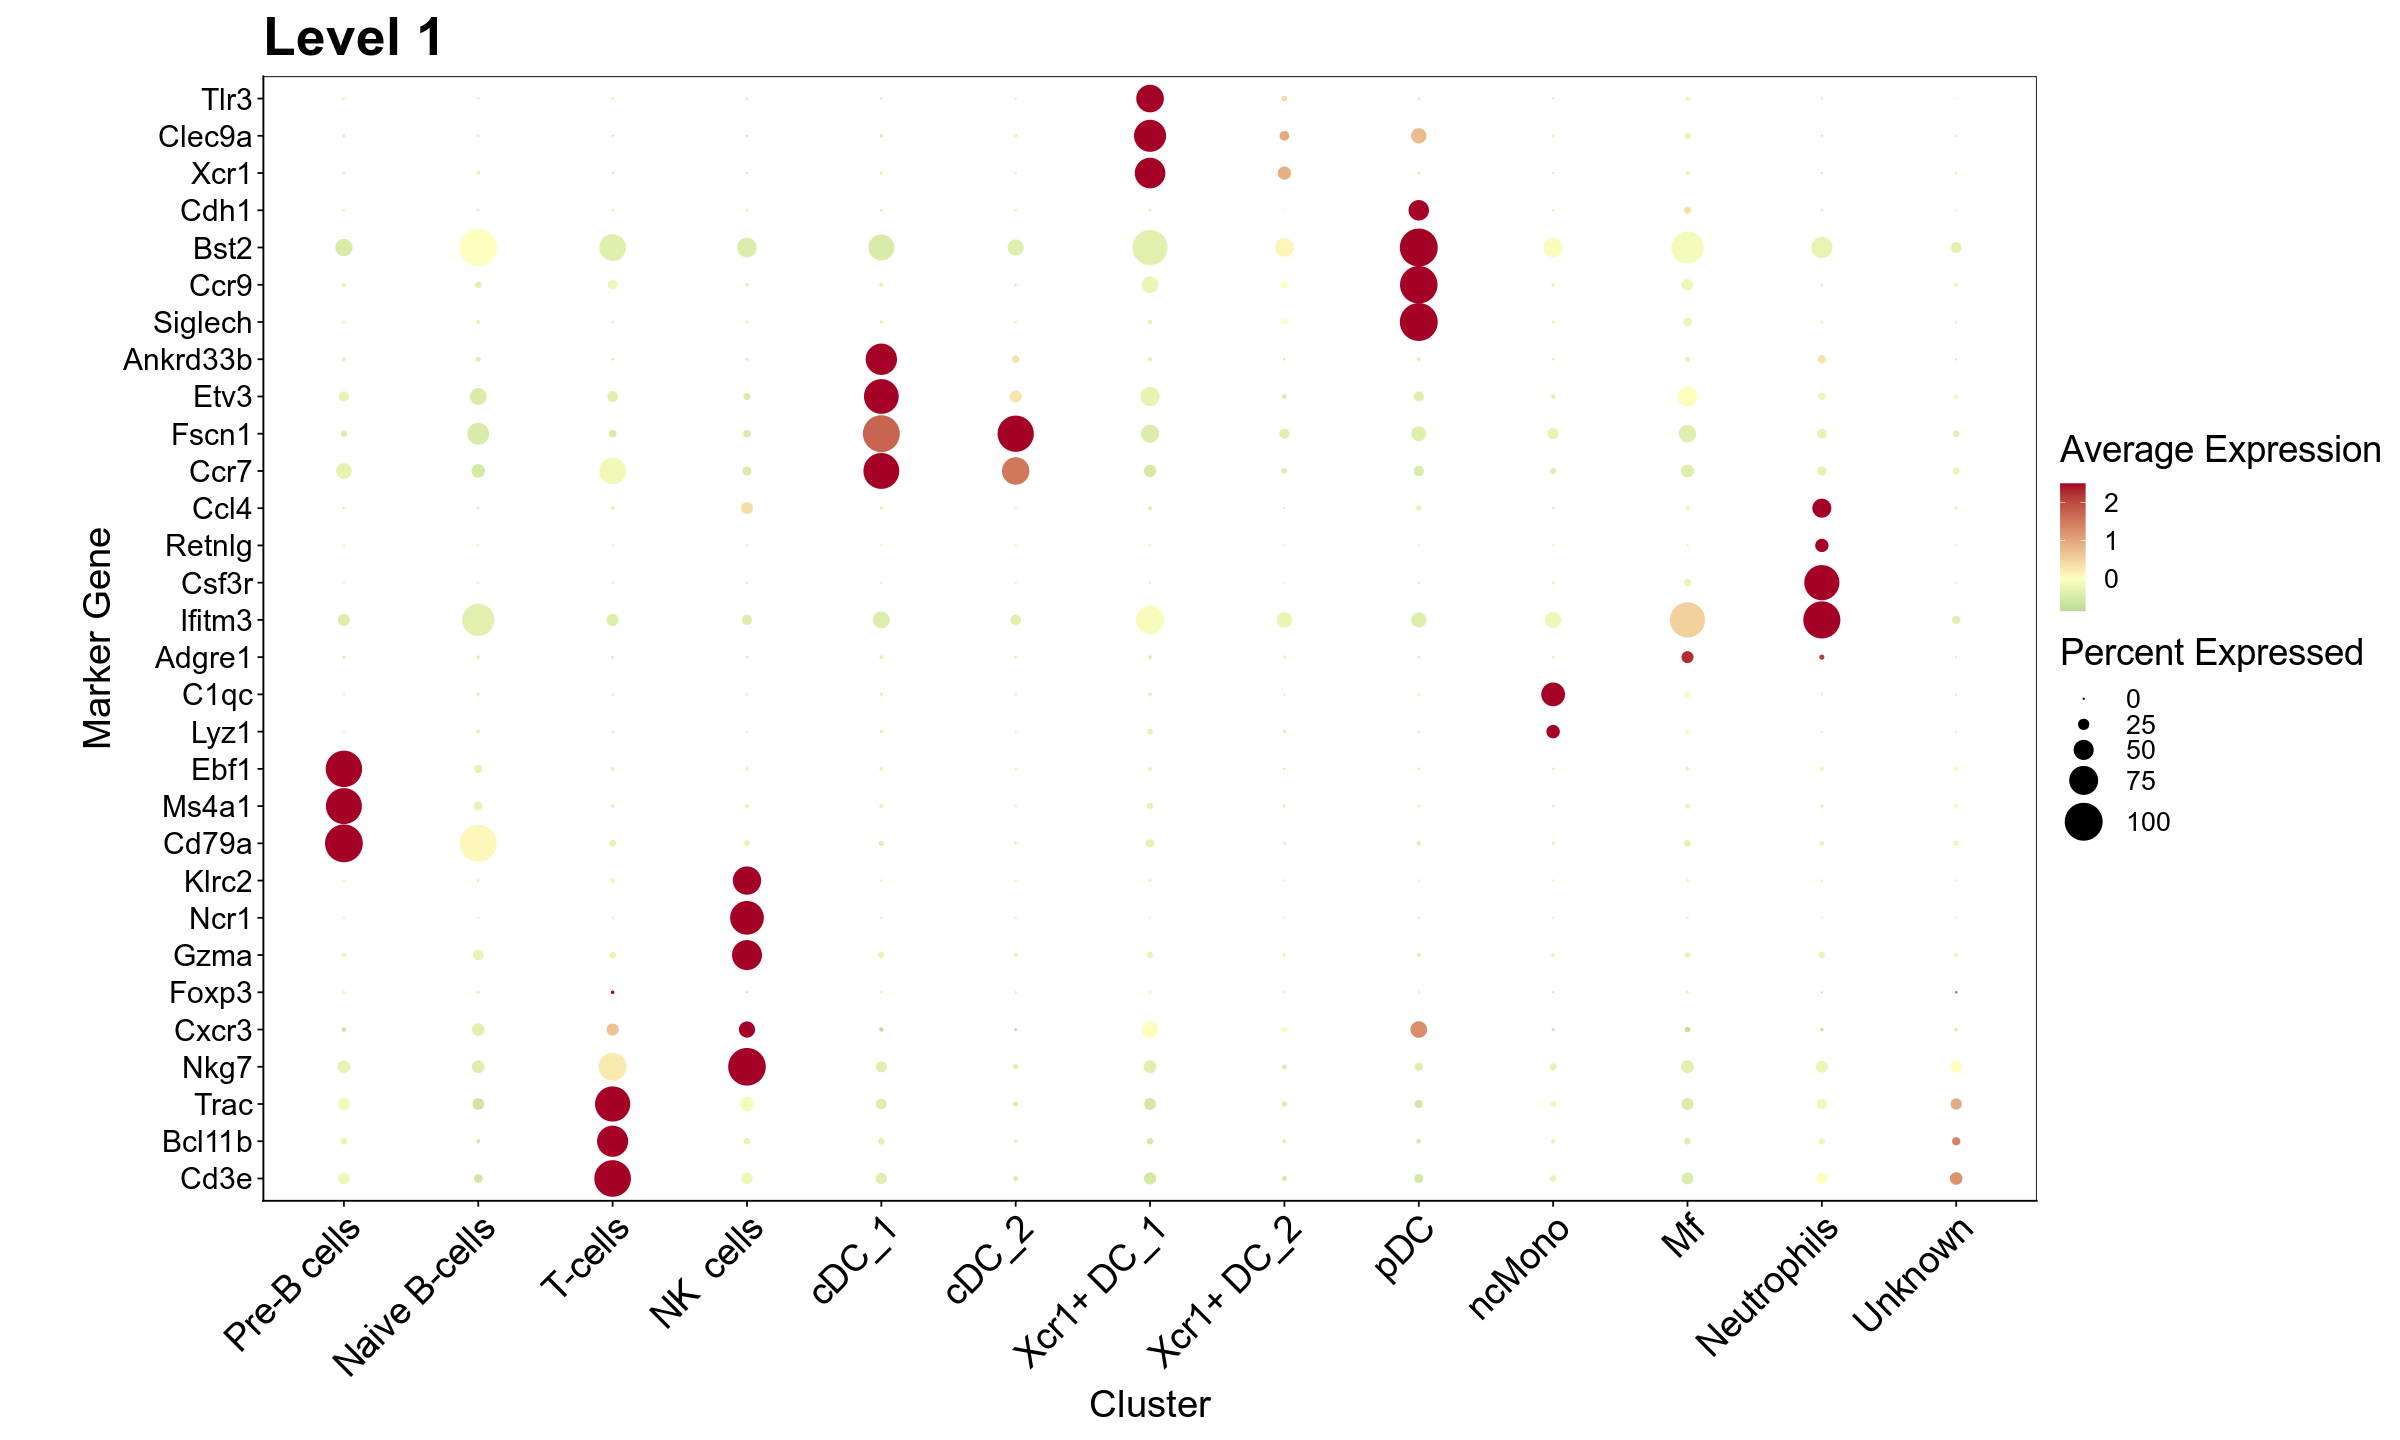

In [65]:
h_ = 12
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

Idents(abc.integrated)<-'Cell.Type.Level1'
theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 22), plot.margin = margin(10, 10, 10, 50))

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[10]]
yellow_hex = brewer.pal(n=11, name = 'RdYlBu')[[6]]
red_hex = brewer.pal(n=11, name = 'RdYlBu')[[1]]

suppressWarnings({
    g3<-DotPlot(abc.integrated, features = markers, cols = c('blue', 'red'), assay = 'RNA', 
                cluster.idents = F, 
                dot.scale = 10, scale = T) + 
    RotatedAxis()+coord_flip()+scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex)+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("Level 1")
})

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'dotplot_level1', ext), g3, 
                                             height = h_, width = w_)}

g3

# Level 2

UMAP visualized on the re-run dimensionality reduction on the T cell subsets (the same as subclustering)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



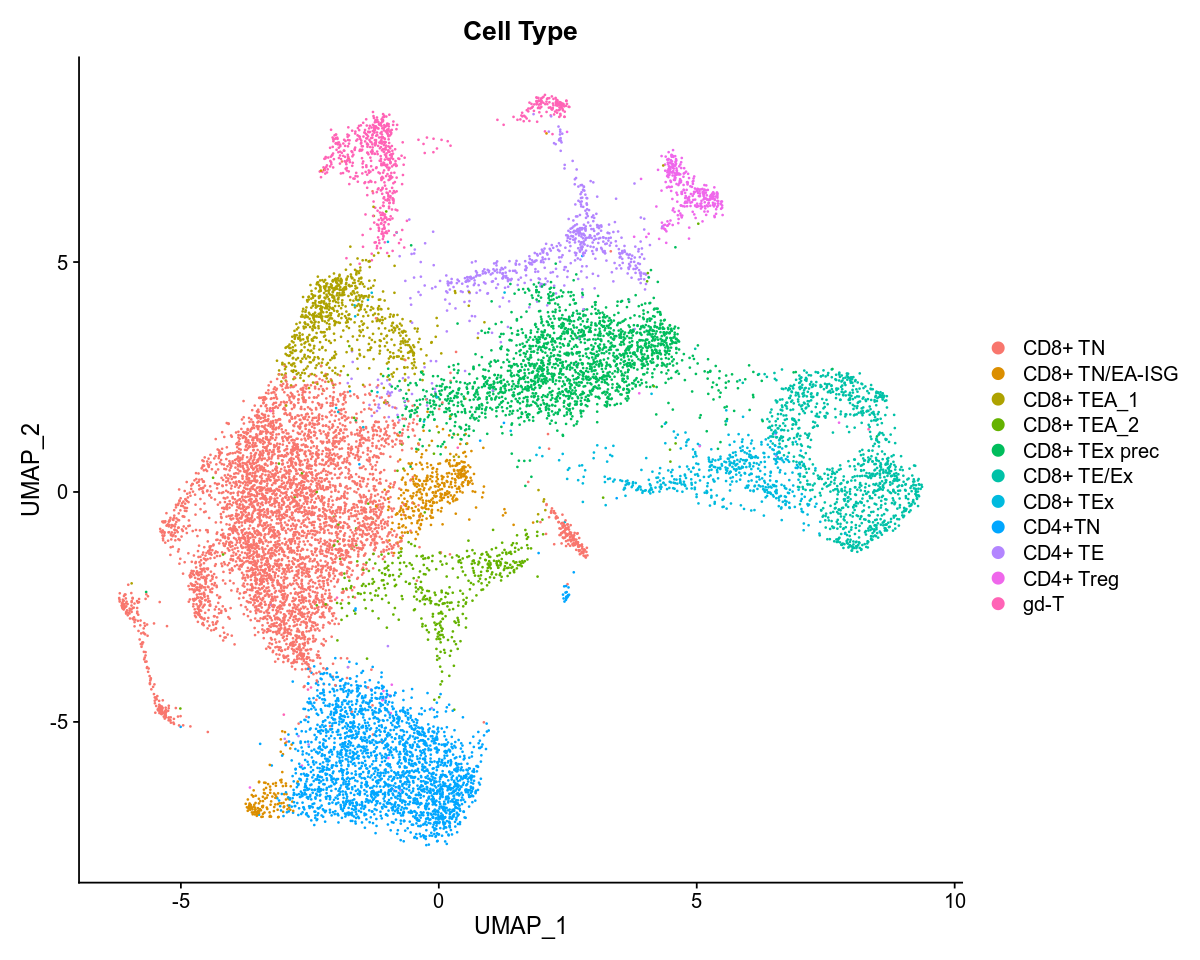

In [71]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

g4 <- DimPlot(abc.tcells, reduction = "umap", group.by = "Cell.Type.Level2", shuffle = T, label = F)+
ggtitle('Cell Type')


suppressWarnings({
   for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'UMAP_celltype_level2_final', ext), g4)}  
})
g4

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



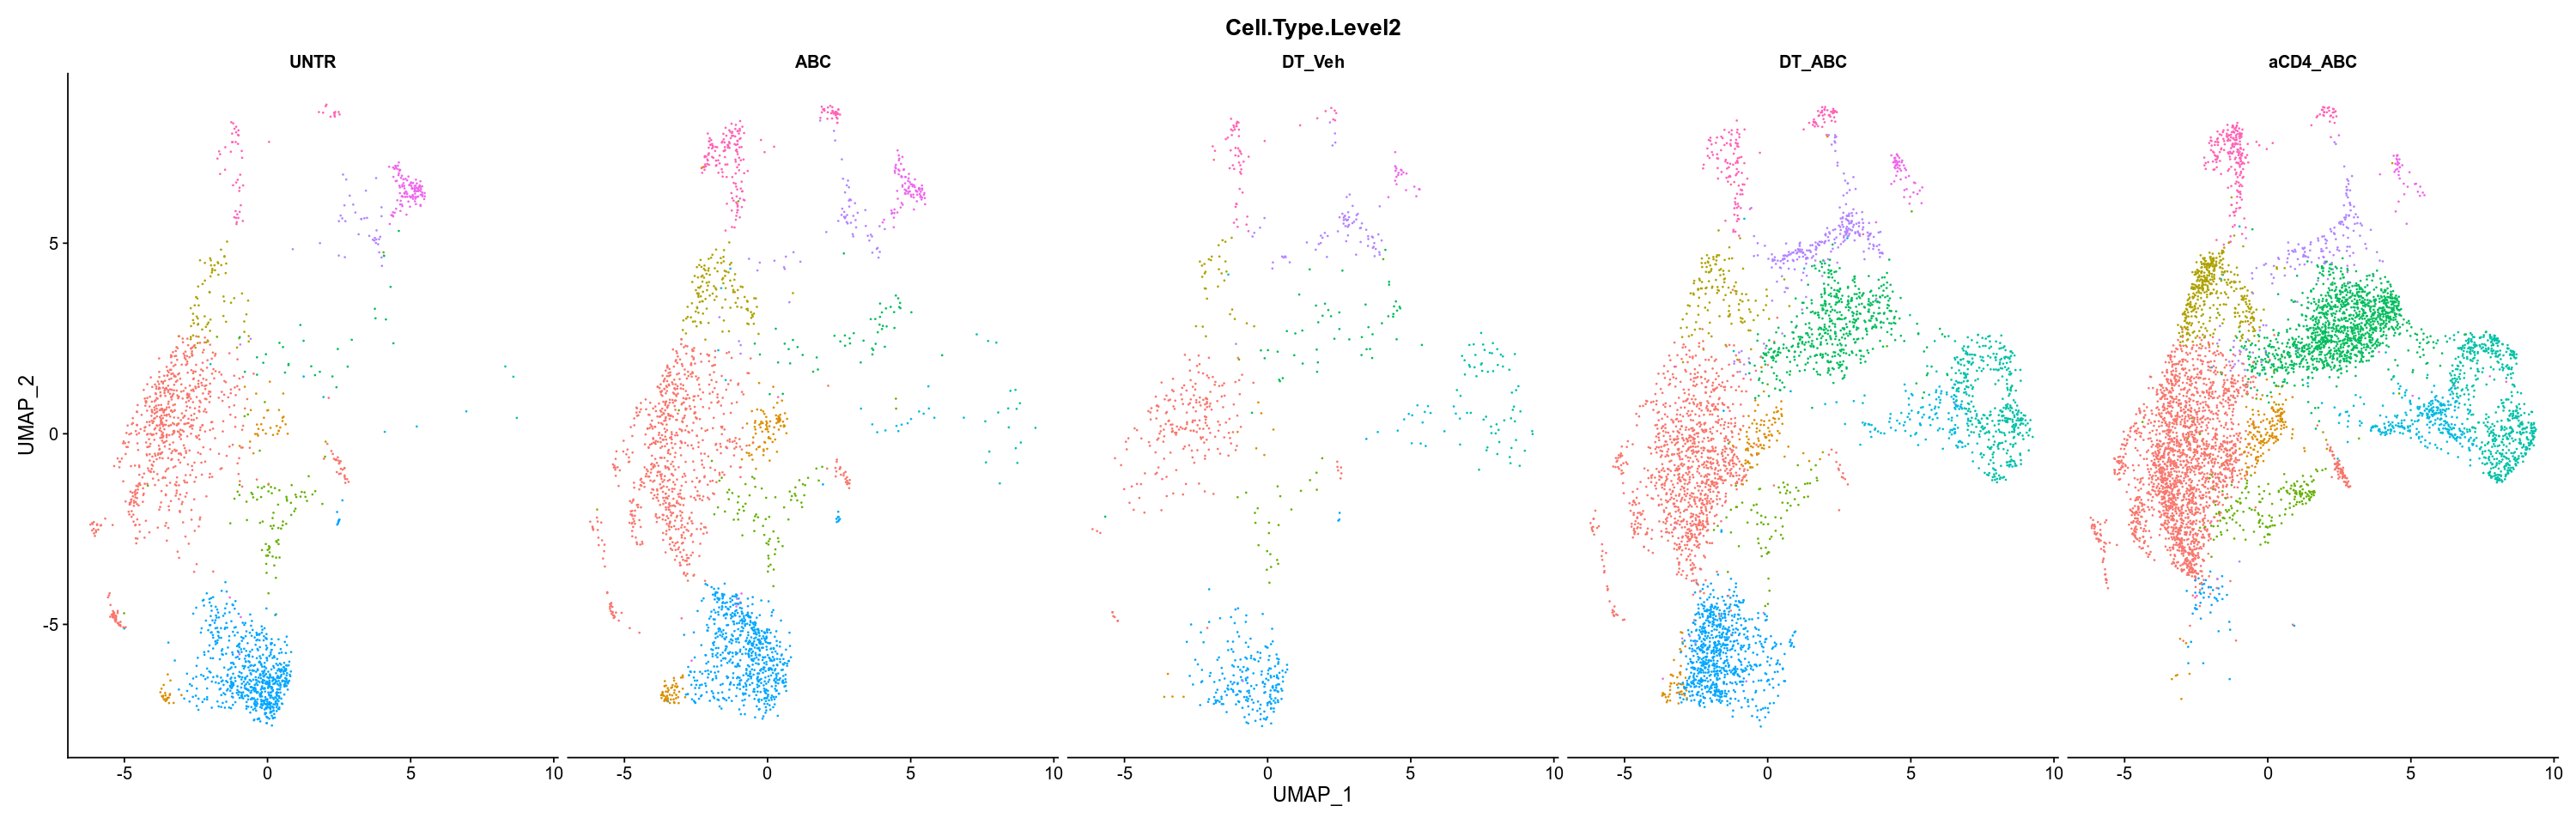

In [72]:
h_ = 8
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

g5 <- DimPlot(abc.tcells, reduction = "umap", group.by = "Cell.Type.Level2", split.by = 'orig.ident', 
              shuffle = T, label = F) + NoLegend()

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'UMAP_celltype_contexts_level2_final', ext), g5)}     
g5

In [73]:
markers<-openxlsx::read.xlsx(paste0(data_path, 'interim/canonical_markers_Tcell.xlsx'))$gene
markers<-unname(sapply(markers, function(x) paste0(toupper(substr(x, 1, 1)), tolower(substr(x, 2, nchar(x))), sep="")))
markers<-unique(markers)
                       

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



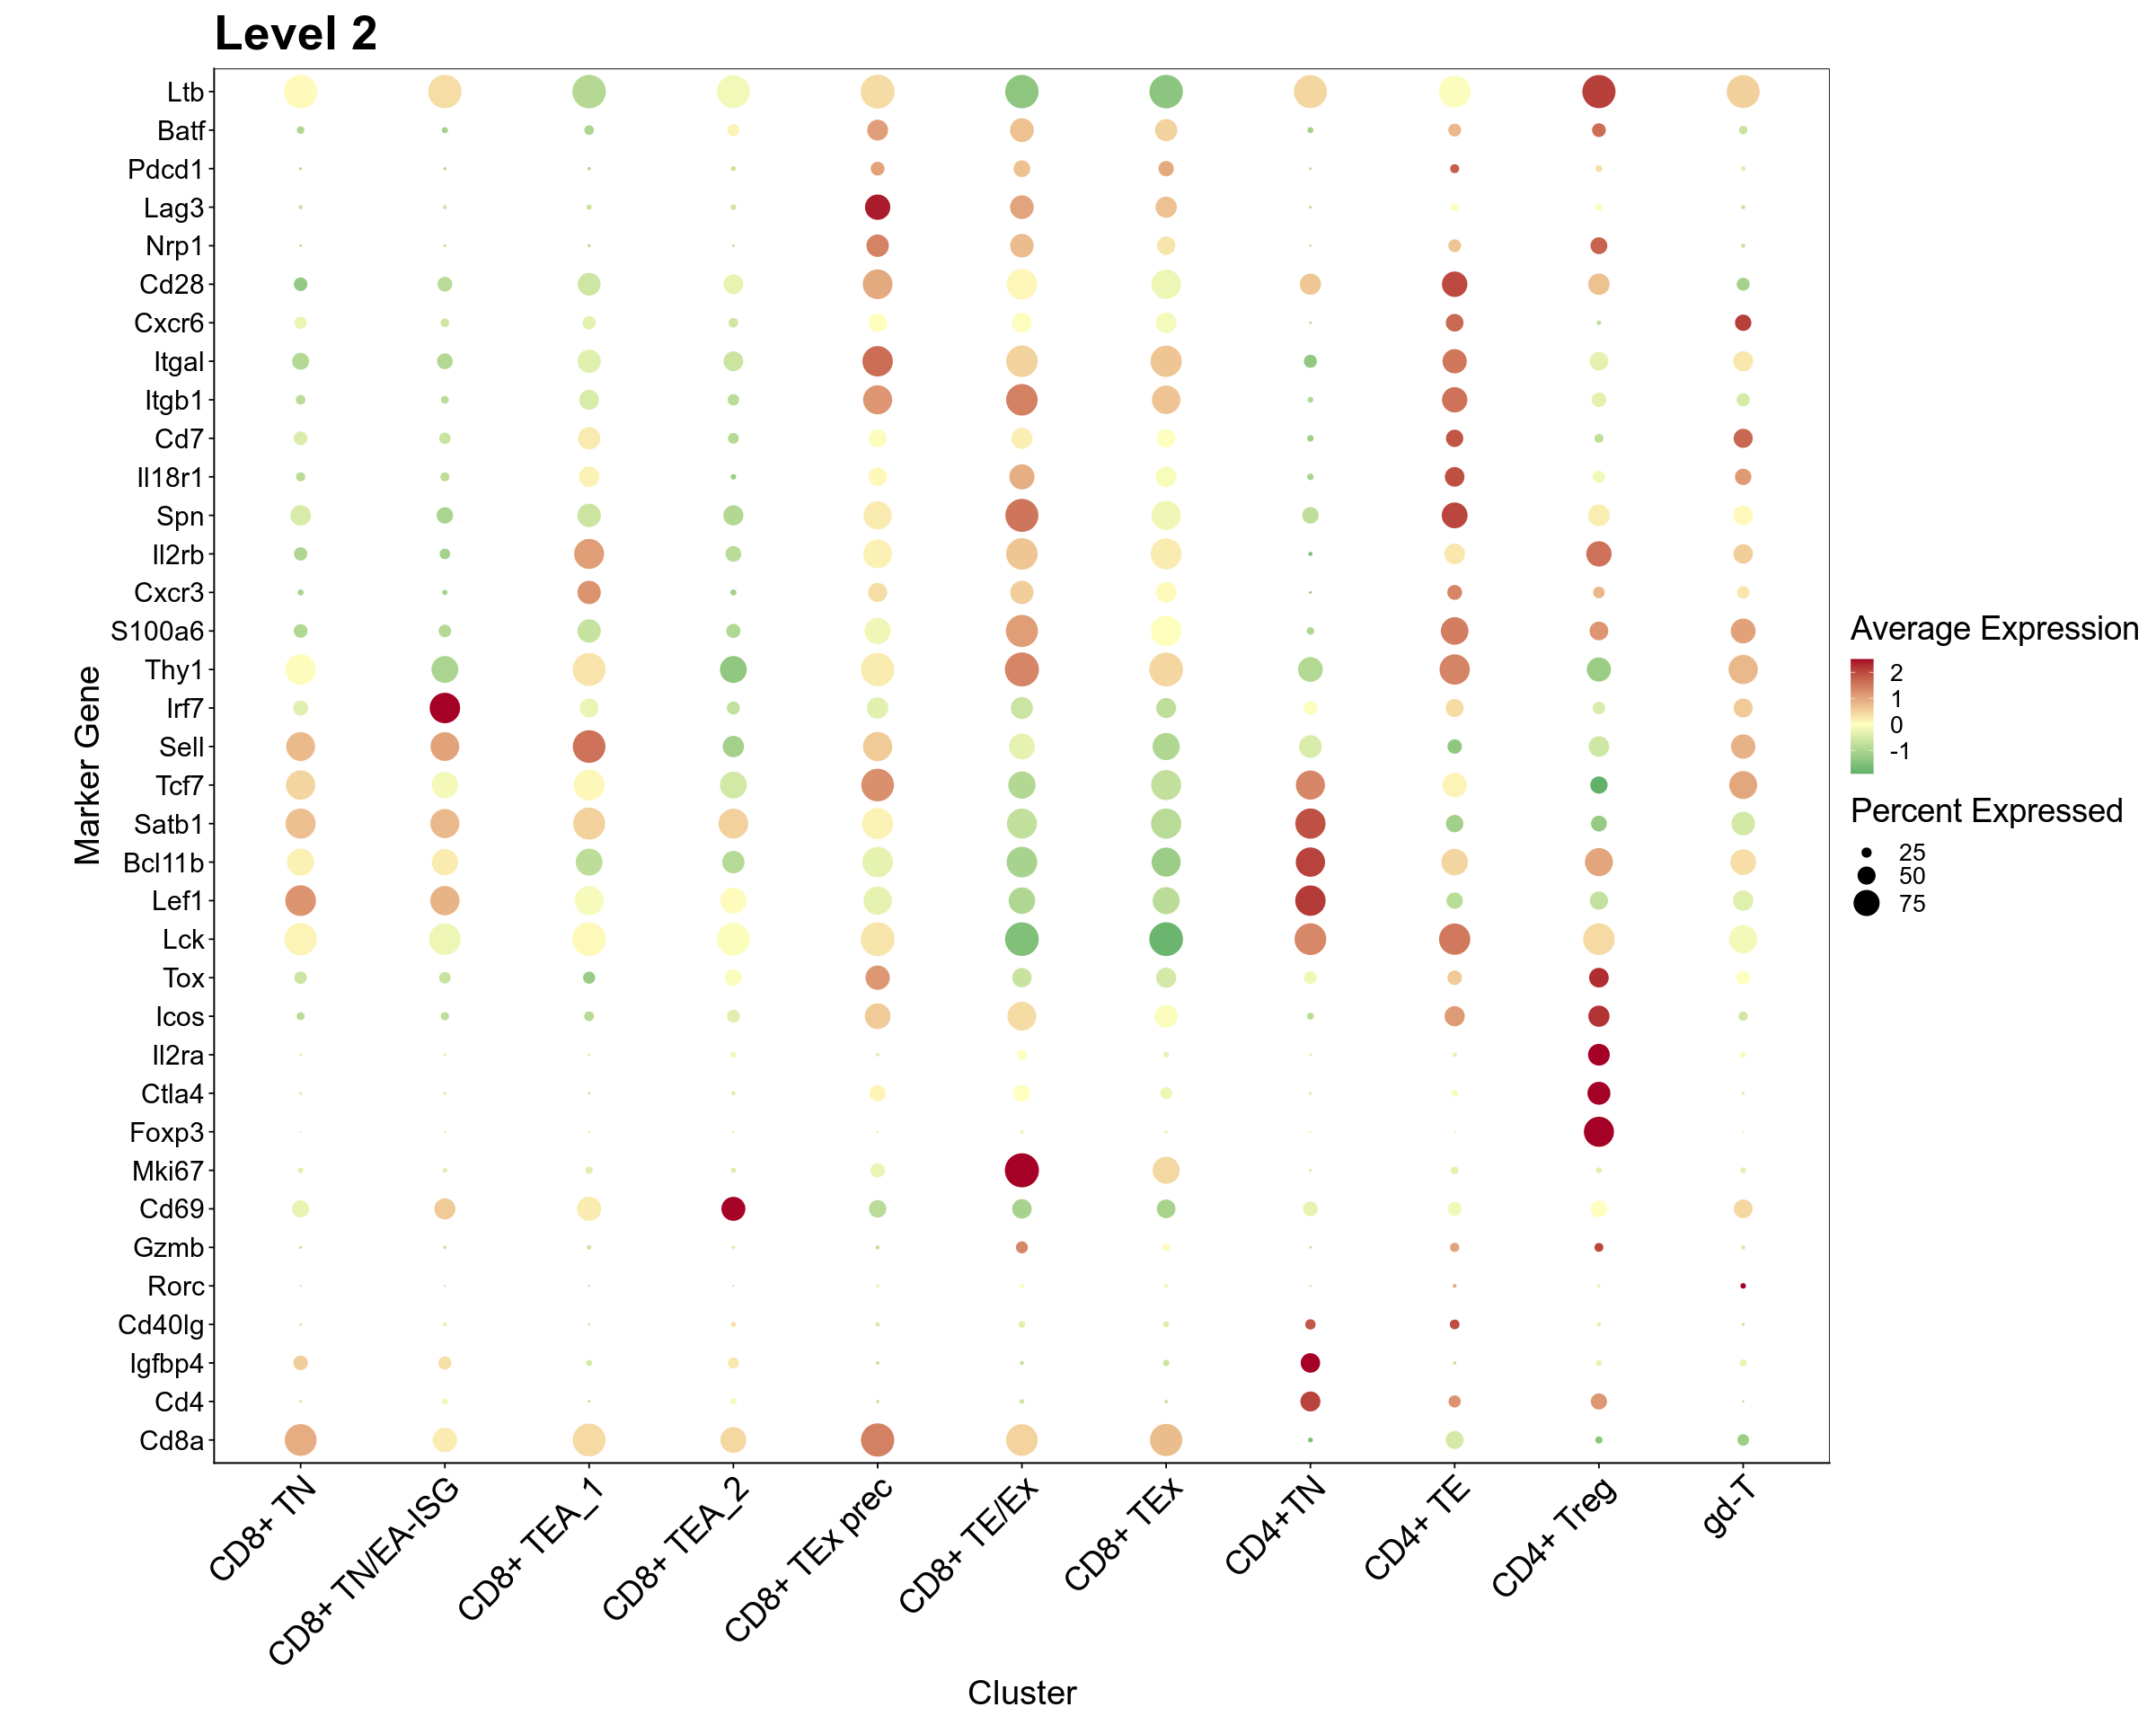

In [77]:
h_ = 16
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

Idents(abc.tcells)<-'Cell.Type.Level2'

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 22), plot.margin = margin(10, 10, 10, 50))

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[10]]
yellow_hex = brewer.pal(n=11, name = 'RdYlBu')[[6]]
red_hex = brewer.pal(n=11, name = 'RdYlBu')[[1]]

suppressWarnings({
    g6<-DotPlot(abc.tcells, features = markers, cols = c('blue', 'red'), assay = 'RNA', 
                cluster.idents = F, 
                dot.scale = 10, scale = T) + 
    RotatedAxis()+coord_flip()+scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex)+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("Level 2")
})


suppressWarnings({
    for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'dotplot_level2', ext), g6, 
                                             height = h_, width = w_)}
})

g6